In [1]:
# Enable automatic import reloading
%load_ext autoreload
%autoreload 2

# Display outputs from all lines when they exist
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # "last"

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import triadicsim

# Library/Import simulation utilities

## Graph generator

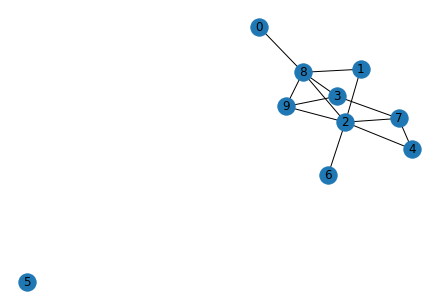

In [3]:
# Create a Gnp graph
G = triadicsim.graph(num_nodes=10, graph_type='Gnp', params={'p':0.3})
nx.draw(G, with_labels=True)

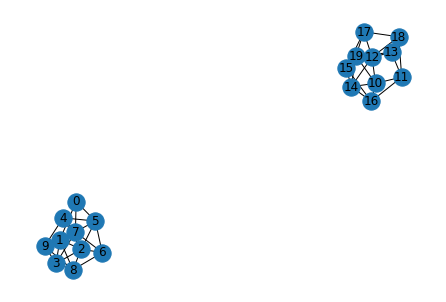

In [4]:
# Create a SBM graph
# NOTE community member node IDs are sequential
G = triadicsim.graph(num_nodes=20, graph_type='stochastic')
nx.draw(G, with_labels=True)

## Triadic closures

In [5]:
# Get list of mutual connections between unconnected pairs of nodes
triadicsim.get_pair_mutuals(G)[:5]

[((2, 7), 5), ((12, 19), 5), ((2, 9), 4), ((7, 8), 4), ((10, 15), 4)]

[(2, 7), (12, 19), (2, 9), (7, 8), (10, 15)]

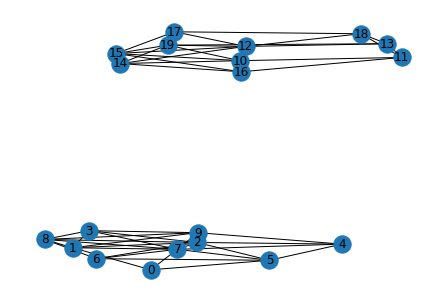

In [6]:
# Perform one round of edge creation
new_conns = triadicsim.closure_round(
    G, num_edges=5, method='max')
nx.draw(G, with_labels=True)
new_conns

## Cascading

In [7]:
# Randomly select seeds out of a given set of node IDs
triadicsim.get_seedset(np.arange(10), 2)

array([1, 3])

## Threshold assignment

array([0.20419821, 0.06904856, 0.76006181, 0.51137437, 0.4574513 ])

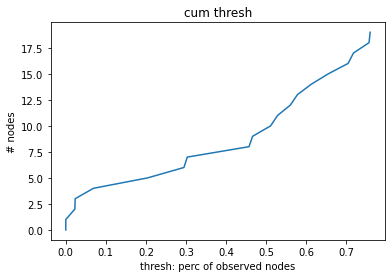

In [8]:
# Assign thresholds to all nodes
thresholds = triadicsim.get_thresholds(len(G))
thresholds[:5]

# Show cumulative distribution
thresholds_sorted = sorted(thresholds)
cum_thresh = [(thresholds_sorted[i], i) for i in range(len(thresholds_sorted))]
_ = plt.plot([x[0] for x in cum_thresh], [x[1] for x in cum_thresh])
_ = plt.title('cum thresh')
_ = plt.xlabel('thresh: perc of observed nodes')
_ = plt.ylabel('# nodes')
plt.show()

## Graph cascading

In [10]:
total_active, r, active_nodes = triadicsim.cascade_population(G, thresholds)
total_active, r
active_nodes

(20, 3)

array([4., 5., 3., 4., 4., 5., 2., 4., 3., 5., 4., 4., 5., 5., 4., 4., 4.,
       3., 3., 3.])

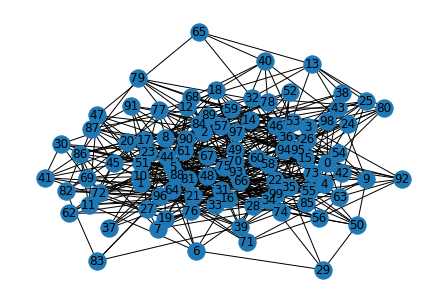

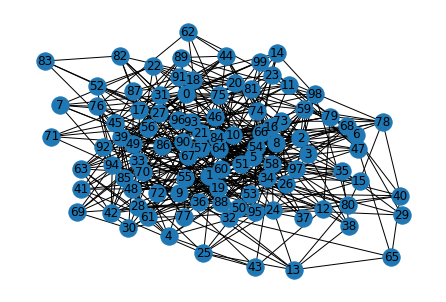

88

19

array([ 1.,  3., 20.,  1.,  2., 19.,  1.,  1.,  3., 20.,  1.,  1.,  0.,
        0.,  1.,  1.,  6., 19., 19.,  3.,  1., 20.,  0., 20., 20.,  0.,
       18.,  2.,  3.,  0., 19.,  1.,  1.,  3.,  1., 20.,  0.,  2., 18.,
        2., 20.,  3.,  3.,  3.,  3.,  0., 20.,  3., 19.,  2.,  0.,  4.,
        2.,  0.,  0., 19.,  1.,  1.,  2.,  2.,  1.,  3., 19.,  3.,  2.,
        1., 18.,  2., 18., 18.,  1.,  1.,  1.,  0.,  1.,  2., 20.,  1.,
       20.,  2.,  1.,  2.,  1.,  2.,  0., 20.,  1.,  2.,  3.,  3.,  2.,
        2., 18., 20., 19.,  2.,  1.,  1.,  1.,  2.])

array([15, 21, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 29,
       42, 61, 88])

In [13]:
def cascade_graph(G, thresholds, 
                  seed_set=None, num_seeds=10,
                  num_add_edges=0,
                  closure_method='random', 
                  max_rounds=20):
    # Initalize active nodes
    if seed_set is None:
        seed_set = triadicsim.get_seedset(len(G.nodes), num_seeds)
    active_nodes = np.zeros((num_nodes))
    active_nodes[seed_set] = 1
    new_active_nodes = np.zeros((num_nodes))
    num_reached_nodes = []

    def get_num_active_neighbors(G, n):
        """Number of active neighbors"""
        neighbors = list(G[n])
        if len(neighbors) == 0: return 0
        num_active_neighbors = np.count_nonzero([active_nodes[neighbor] for neighbor in neighbors])
        return num_active_neighbors


    prev_total_active = np.sum(active_nodes)
    # Iterate over rounds
    for r in range(max_rounds):
        for n in G.nodes():
            num_active_neighbors = get_num_active_neighbors(G, n)
            
            if len(G[n]) == 0:
                continue
            
            active_visible = num_active_neighbors / len(G[n])
            
            if thresholds[n] <= active_visible:
                new_active_nodes[n] += 1
        active_nodes = new_active_nodes
        total_active = np.count_nonzero(active_nodes)
        num_reached_nodes.append(total_active)

        if total_active == num_nodes:
            break
        prev_total_active = total_active
        
        added_connections = triadicsim.closure_round(
            G, num_add_edges, method=closure_method)
    return total_active, r, active_nodes, np.asarray(num_reached_nodes)

graph_type='Gnp'
num_nodes = 100
G = triadicsim.graph(num_nodes, graph_type=graph_type)
nx.draw(G, with_labels=True)
plt.show()

closure_method='max'
thresholds = triadicsim.get_thresholds(len(G))
total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                 closure_method=closure_method)
nx.draw(G, with_labels=True)
plt.show()

total_active
r
active_nodes
num_reached_nodes


# Run some experiments

In [ ]:
num_experiments = 20
graph_type='stochastic'
num_nodes = 100
closure_method = 'weighted_random'
max_rounds = 100

def get_title(num_nodes, graph_type, closure_method):
    return f"\n{num_nodes} nodes on {graph_type} with {closure_method} closure"

In [ ]:
def get_round_completed(num_reached_nodes):
    round_completed = np.where(num_reached_nodes == num_nodes)[0]
    if len(round_completed) == 0:
        return -1
    else:
        return round_completed[0]
    
def get_round_max(num_reached_nodes):
    round_completed = np.where(num_reached_nodes == np.max(num_reached_nodes))[0]
    if len(round_completed) == 0:
        return -1
    else:
        return round_completed[0]

In [ ]:
# Vary thresholds, same graph
closure_method = "max"
rounds_completed = []
for i in range(num_experiments):
    G = triadicsim.graph(num_nodes, graph_type=graph_type, seed=0)
    thresholds = triadicsim.get_thresholds(num_nodes)
    
    total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                     closure_method=closure_method, 
                                                                     max_rounds=max_rounds)
    plt.plot(num_reached_nodes / num_nodes)
    rounds_completed.append(get_round_completed(num_reached_nodes))
plt.plot()
plt.xlabel('round')
plt.ylabel('% nodes participating')
plt.title('Vary thresholds, same graph' + get_title(num_nodes, graph_type, closure_method))
print(rounds_completed)

In [ ]:
# Vary thresholds, same graph
closure_method = "static"
rounds_completed = []
for i in range(num_experiments):
    G = triadicsim.graph(num_nodes, graph_type=graph_type, seed=0)
    thresholds = triadicsim.get_thresholds(num_nodes)
    
    total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                     closure_method=closure_method, 
                                                                     max_rounds=max_rounds)
    plt.plot(num_reached_nodes / num_nodes)
    rounds_completed.append(get_round_completed(num_reached_nodes))
plt.plot()
plt.xlabel('round')
plt.ylabel('% nodes participating')
plt.title('Vary thresholds, same graph' + get_title(num_nodes, graph_type, closure_method))
print(rounds_completed)

In [ ]:
G = triadicsim.graph(num_nodes, graph_type=graph_type)
nx.draw(G, with_labels=True)
plt.show()
total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                 closure_method=closure_method)
nx.draw(G, with_labels=True)
plt.show()